# Privacy Preserving Generative Model
This notebook aims to create a generative model which works in Python3

In [1]:
!pip install imageio
!pip install matplotlib
!pip install tqdm

In [2]:
import time, os

# Numpy
import numpy as np

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend

# To generate GIFs


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time


from tqdm import tqdm

from IPython import display
#tf.reset_default_graph()

# Making results reproducible
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wi

In [3]:
def preprocess_real_samples(samples):
    samples = samples.astype('float32').reshape(-1, 28, 28, 1)
    samples = (samples - samples.min()) / (samples.max() - samples.min())
    return samples

def plot_4_by_4_images(x, save = False, savefile="img.png"):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(x.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :, 0], cmap='gray')
    if save:
        plt.savefig(savefile)
    plt.show()

In [4]:
def generator_model():
    def square_activation(x):
        return x * x
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(Activation(square_activation))

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(Activation(square_activation))    

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(Activation(square_activation))
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    #model.compile(loss='binary_crossentropy', optimizer='adam')
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    return model

In [5]:
def discriminator_model():
    def square_activation(x):
        return x * x
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    #model.add(Activation(square_activation))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    #model.add(Activation(square_activation))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    return model

In [6]:
def gan_model(generator, discriminator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    #gan.compile(loss='binary_crossentropy', optimizer='adam')
    gan.compile(loss='binary_crossentropy', optimizer='sgd')
    return gan

In [7]:
def generate_noise_samples(n=1):
    noise = np.random.normal(0, 1, (n, 100))
    return noise
def generate_fake_samples(n=1):
    noise = generate_noise_samples(n)
    X = generator.predict(noise)
    return X

In [8]:
def generate_and_save_images(noise_test, epoch, batch):
    display.clear_output(wait=True)
    fake_images = generator.predict(noise_test)
    plot_4_by_4_images(fake_images, save=True, savefile='img/image_at_epoch_{:04d}_{:04d}.png'.format(epoch, batch))

In [9]:
def train_step(real_images, batch_size=64):
    real_label = np.ones((batch_size, 1))
    generated_images = generate_fake_samples(batch_size)
    generated_labels = np.zeros((batch_size, 1))

    X_dis = np.concatenate([real_images, generated_images])
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9
        
    discriminator.trainable = True
    discriminator.train_on_batch(X_dis, y_dis)
    #discriminator.train_on_batch(x_fake, y_fake)
        
    discriminator.trainable = False
    x_gan = generate_noise_samples(batch_size)
    y_gan = np.ones((batch_size, 1)) # We assume that we wanted true as answer from the discriminator
    gan.train_on_batch(x_gan, y_gan)

In [10]:
def train(dataset, epochs=50, batch_size=64):
    m = dataset.shape[0]
    m_batch = m // batch_size
    noise_test = np.random.normal(0,1, [20, 100])
    toc = time.time()
    for epoch in range(epochs):
        tic = time.time()
        for batch_num in range(m_batch):
            if batch_num % 30 == 0:
                #print ('[{}%] Time for epoch {} is {} sec'.format((batch_num / m_batch) * 100,epoch + 1, time.time()-tic), end='\r')
                #generate_and_save_images(noise_test, epoch, batch_num)
                print("[%0.2f%%] Time for epoch %d is %f sec" % ( (batch_num / m_batch) * 100, epoch + 1, time.time()-tic), end='\r')
                
            batch_slot = batch_size * batch_num
            batch = dataset[batch_slot: batch_slot + batch_size]
            train_step(batch, batch_size)
        #Extra
        if time.time() - toc  > 30:
            toc = time.time()
        generate_and_save_images(noise_test, epoch, batch_num)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-tic))

## Loading the model and testing it

In [11]:
from tensorflow.keras.models import load_model
generator = load_model('generator_apple.h5')
discriminator = load_model('discriminator_apple.h5')
gan = load_model('gan_apple.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


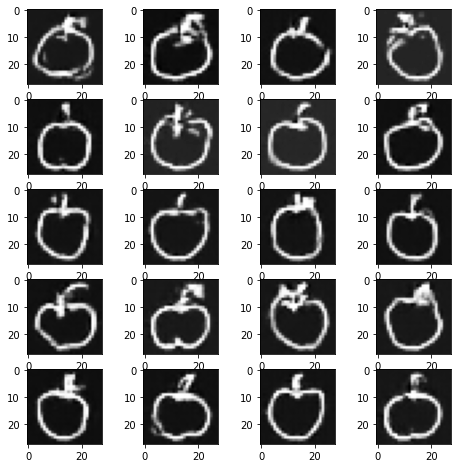

In [12]:
import numpy as np
fake_images = generator.predict(np.random.normal(0,1,[20, 100]))
plot_4_by_4_images(fake_images)

## Training the normal model

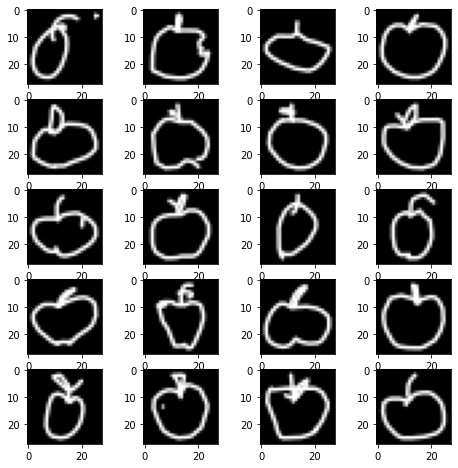

In [13]:
# Making results reproducible
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

dataset = np.load('apple.npy')
dataset = preprocess_real_samples(dataset) 
plot_4_by_4_images(dataset)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

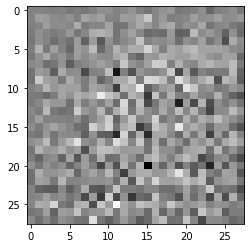

In [14]:
noise = np.random.normal(0, 1, [1, 100])
generator = generator_model()
generator.summary()
generated_image = generator.predict(noise)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:
discriminator = discriminator_model()
discriminator.summary()
pred= discriminator.predict(generated_image)
print(pred, pred > 0.5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [16]:
gan = gan_model(generator, discriminator)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         2330944   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


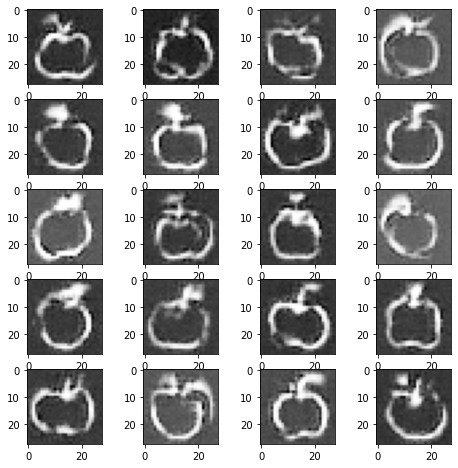

Time for epoch 50 is 17.083011627197266 sec


In [17]:
train(dataset[:5000], 50, 32)

In [18]:
generator.save('generator_apple_%d.h5' % (int(time.time())))
discriminator.save('discriminator_apple_%d.h5' % (int(time.time())))
gan.save('gan_apple_%d.h5' % (int(time.time())))

## Training with modified activation functions

In [19]:
def generator_model_sq():
    def square_activation(x):
        return x * x
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(Activation(square_activation)) ##Change with respect to previous

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(Activation(square_activation)) ##Change with respect to previous 

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(Activation(square_activation)) ##Change with respect to previous
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(Activation(square_activation)) ##Change with respect to previous
    assert model.output_shape == (None, 28, 28, 1)
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    
    return model

In [20]:
def discriminator_model_sq():
    def square_activation(x):
        return x * x
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(Activation(square_activation)) ##Change with respect to previous
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(square_activation)) ##Change with respect to previous
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(Activation(square_activation)) ##Change with respect to previous
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [21]:
def gan_model_sq(generator, discriminator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    #gan.compile(loss='binary_crossentropy', optimizer='adam')
    gan.compile(loss='binary_crossentropy', optimizer='sgd')
    return gan

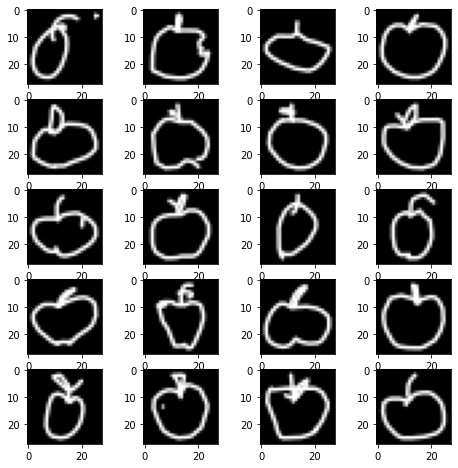

In [22]:
# Making results reproducible
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

dataset = np.load('apple.npy')
dataset = preprocess_real_samples(dataset) 
plot_4_by_4_images(dataset)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
activation (Activation)      (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)        

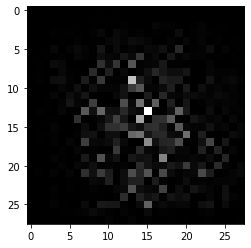

In [23]:
noise = np.random.normal(0, 1, [1, 100])
generator = generator_model_sq()
generator.summary()
generated_image = generator.predict(noise)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [24]:
discriminator = discriminator_model_sq()
discriminator.summary()
pred= discriminator.predict(generated_image)
print(pred, pred > 0.5)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_5 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [25]:
gan = gan_model_sq(generator, discriminator)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         2330944   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


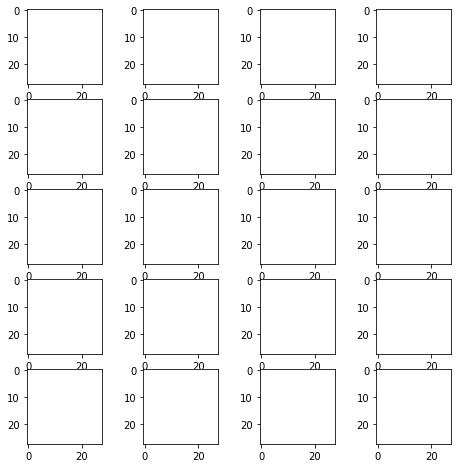

Time for epoch 50 is 16.52961015701294 sec


In [26]:
train(dataset[:5000], 50, 32)